# Implementing a Cybersecurity Management System for IIoT

# Settings

In [1]:
# Import der benötigten Packages

import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import pyshark 
import requests
import time
import nvdlib
import funs
import sys
import os
import csv
import re 
import textwrap

from bs4 import BeautifulSoup
from scapy.all import rdpcap, PcapReader
from SMET import map_text

# Einstellungen für die vollständige Anzeige des DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

C:\Users\Marce\anaconda3\envs\smet_envir\lib\site-packages\scapy\layers\ipsec.py:512: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  cipher=algorithms.TripleDES,
C:\Users\Marce\anaconda3\envs\smet_envir\lib\site-packages\scapy\layers\ipsec.py:516: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  cipher=algorithms.TripleDES,
error loading _jsonnet (this is expected on Windows), treating C:\Users\Marce\AppData\Local\Temp\tmpslcfw6jd\config.json as plain json
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.b

In [4]:
mac_ip_dict = {}

# Extrahieren der Source MAC- und IP-Adressen
for packet in packets:
    if packet.haslayer('Ether') and packet.haslayer('IP'):
        source_mac = packet.src
        source_ip = packet[1].src
        if source_mac not in mac_ip_dict:
            mac_ip_dict[source_mac] = set()
        mac_ip_dict[source_mac].add(source_ip)

# Filtern der unterschiedlichen MAC Adressen 
unique_mac_count = len(mac_ip_dict)

# Ausgabe der unterschiedlichen Source MAC-Adressen mit den zugehörigen IP-Adressen
print(f"Anzahl unterschiedlicher Source MAC-Adressen: {unique_mac_count}")
print("Unterschiedliche Source MAC-Adressen und ihre IP-Adressen:")
for mac, ips in mac_ip_dict.items():
    print(f"MAC-Adresse: {mac}")
    for ip in ips:
        print(f"  IP-Adresse: {ip}")

Anzahl unterschiedlicher Source MAC-Adressen: 3
Unterschiedliche Source MAC-Adressen und ihre IP-Adressen:
MAC-Adresse: 00:18:92:18:20:cf
  IP-Adresse: 192.168.42.197
MAC-Adresse: 00:04:17:08:b6:d0
  IP-Adresse: 192.168.42.196
MAC-Adresse: cc:48:3a:57:5e:f4
  IP-Adresse: 192.168.42.250


In [ ]:
# Mapping MAC Adresse mit Hersteller

def get_mac_vendor(mac):
    url = f'https://api.macvendors.com/{mac}'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            return 'Unbekannter Hersteller'
    except requests.RequestException as e:
        return 'Anfrage fehlgeschlagen'

def get_mac_vendor_info(mac_ip_dict):
    mac_vendor_info = {}
    for mac in mac_ip_dict.keys():
        vendor = get_mac_vendor(mac)
        mac_vendor_info[mac] = vendor
        time.sleep(1)  # Verzögerung, da sonst fehlerhafte Abfrage
    return mac_vendor_info


# Hoerstellerinfo für jede eindeutige MAC-Adresse
mac_vendor_info = get_mac_vendor_info(mac_ip_dict)

print("Herstellerinformationen:", mac_vendor_info)

print(f"Anzahl unterschiedlicher Source MAC-Adressen: {len(mac_ip_dict)}")


# Einlesen Zusatzdatei

In [2]:
#file_path = 'C:/Users/Marce/Masterarbeit/Devices.txt' #add your path 
file_path = '' #add your path 

# Liste für Gerätenamen, Softwarenamen und Gerät-Software Paaren
device_names = []
software_names = []
device_software_pairs = []

with open(file_path, 'r') as file:
    # Skip Header
    next(file)
    for line in file:
        # Semikolon als Splitattribut
        parts = line.strip().split(';')
        if len(parts) >= 4:
            device_name = parts[2].strip()
            software_name = parts[3].strip()
            # Append to the lists
            device_names.append(device_name)
            software_names.append(software_name)
            # Create a tuple of device and software
            device_software_pairs.append((device_name, software_name))

print("Hardware:")
for device in device_names:
    print(device)

print("\nSoftware:")
for software in software_names:
    print(software)

Hardware:
ADS-TEC OPC9000
Schneider Electric Sage 2300
Simatic S7-200
Rockwell Automation MicroLogix 1400 Controllers Series B
Skylab IGX IIoT Gateway
Moxa UC Series IPC
Bosch BMP280
Mitsubishi Electric smartRTU

Software:
OPC9000 Monitoring Suite v1.8
C3413-500-001D3_P4
MicroWin V4.0
RSLogix 500
Eclipse Mosquitto 2.0.9
Moxa Industrial Linux v1.2
Bosch Sensortec BMP280 API v1.0
MELSOFT RT ToolBox3 Version 1.1


# Entfernung der spezifischen Softwareversionen

In [3]:
def remove_version(software_name):
    # Splitte den Software-Namen an Leerzeichen
    parts = software_name.split()
    
    # Überprüfung ob Versionsnummer oder Zahl
    cleaned_parts = []
    for part in parts:
        # Prüfen, ob es eine Versionsnummer ist (z.B. "v1.2", "2.0.9", "Version 1.1", "500")
        if not (part.startswith('v') or part.startswith('V') or part.lower().startswith('version') or re.match(r'^\d+(\.\d+)*$', part) or part.isdigit()):
            cleaned_parts.append(part)
        else:
            break  # Beenden, sobald eine Versionsnummer gefunden wurde
    
    # Teile wieder zusammenfügen und zurückgeben
    return ' '.join(cleaned_parts)

# Anwenden der Funktion auf die Software-Liste
cleaned_software_list = [remove_version(software) for software in software_names]
cleaned_device_software_pairs = [(device, remove_version(software)) for device, software in device_software_pairs]

# Ausgabe der bereinigten Software-Liste
for software in cleaned_software_list:
    print(software)

OPC9000 Monitoring Suite
C3413-500-001D3_P4
MicroWin
RSLogix
Eclipse Mosquitto
Moxa Industrial Linux
Bosch Sensortec BMP280 API
MELSOFT RT ToolBox3


# CVE Suche Hardware und Software 

In [67]:
# URL der NVD API
url = "https://services.nvd.nist.gov/rest/json/cves/2.0"

# User-Agent-Header und API-Schlüssel
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36",
    "apikey": "20d7639e-4814-4f76-861d-23ad4686bd0d"
}

def get_cvss_and_epss_score(cve_id):
    # Anfrage an die NVD API
    cve = nvdlib.searchCVE(cveId=cve_id, key="20d7639e-4814-4f76-861d-23ad4686bd0d")
    
    if cve:
        cve_item = cve[0]
        
        # Extrahieren des CVSS Scores
        cvss_score = "N/A"
        severity = "N/A"
        if hasattr(cve_item, 'v31severity'):
            cvss_score = cve_item.v31score
            severity = cve_item.v31severity
        elif hasattr(cve_item, 'v30severity'):
            cvss_score = cve_item.v30score
            severity = cve_item.v30severity
        
        # Abfragen des EPSS Scores
        epss_score = "N/A"
        epss_url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        response = requests.get(epss_url)
        if response.status_code == 200:
            epss_data = response.json()
            if epss_data['data']:
                epss_score = epss_data['data'][0]['epss']
        
        return cvss_score, severity, epss_score
    else:
        return "N/A", "N/A", "N/A"

def get_cve_data(item_list, item_type):
    all_cve_data = []

    # Variable zur Verfolgung der gesendeten Anfragen an NVD
    requests_sent = 0
    start_time = time.time()

    # Durchlaufen der Liste der Bezeichnungen
    for item_name in item_list:
        start_index = 0
        item_cve_data_found = False  # Variable zum Verfolgen, ob CVE-Daten gefunden wurden
        while True:
            # Parameter für die Anfrage
            params = {
                "keywordSearch": item_name,
                "resultsPerPage": 100,
                "startIndex": start_index
            }

            # Überprüfung, ob das Rate Limit der API erreicht wurde
            if requests_sent >= 5:
                elapsed_time = time.time() - start_time
                if elapsed_time < 30:
                    time.sleep(100 - elapsed_time)
                requests_sent = 0
                start_time = time.time()

            # Anfrage an die NVD API
            response = requests.get(url, headers=headers, params=params)
            requests_sent += 1
            
            # Überprüfung der Anfrage
            if response.status_code == 200:
                data = response.json()
                cve_items = data.get("vulnerabilities", [])

                if not cve_items:
                    break

                item_cve_data_found = True  # True, falls Daten gefunden wurden

                # Extrahieren der relevanten Informationen
                for item in cve_items:
                    cve_id = item["cve"]["id"]
                    description = item["cve"]["descriptions"][0]["value"]
                    published_date = item["cve"]["published"]
                    last_modified_date = item["cve"]["lastModified"]
                    weaknesses = item["cve"].get("weaknesses", [])
                    vulnerabilities = [weakness["description"] for weakness in weaknesses] if weaknesses else ["N/A"]

                    cvss_score, severity, epss_score = get_cvss_and_epss_score(cve_id)

                    configurations = []
                    if "configurations" in item["cve"]:
                        for node in item["cve"]["configurations"][0]["nodes"]:
                            if "cpeMatch" in node:
                                for config in node["cpeMatch"]:
                                    configurations.append(config.get("criteria", "N/A"))

                    all_cve_data.append({
                        item_type: item_name,
                        "CVE ID": cve_id, 
                        "Description": description, 
                        "Published Date": published_date,
                        "Last Modified Date": last_modified_date,
                        "Vulnerabilities": vulnerabilities,
                        "CVSS Score": cvss_score,
                        "CVSS Severity": severity,
                        "EPSS Score": epss_score,
                        "Configurations": configurations
                    })
                start_index += 100
            else:
                print(f"Fehler bei der Anfrage für {item_name}: {response.status_code} - {response.text}")
                break

        # Nachricht hinzufügen, wenn keine CVE-Daten gefunden wurden
        if not item_cve_data_found:
            all_cve_data.append({
                item_type: item_name,
                "CVE ID": "N/A", 
                "Description": "No CVE entries found for this item.", 
                "Published Date": "N/A",
                "Last Modified Date": "N/A",
                "Vulnerabilities": ["N/A"],
                "CVSS Score": "N/A",
                "CVSS Severity": "N/A",
                "EPSS Score": "N/A",
                "Configurations": ["N/A"]
            })

    # DataFrame erstellen
    df_cve_data = pd.DataFrame(all_cve_data)

    # Überprüfen, ob 'Published Date' in den Daten vorhanden ist
    if 'Published Date' in df_cve_data.columns:
        # Sortieren der Daten nach dem Veröffentlichungsdatum
        df_cve_data['Published Date'] = pd.to_datetime(df_cve_data['Published Date'], errors='coerce')
        df_cve_data = df_cve_data.sort_values(by=[item_type, 'Published Date'], ascending=[True, False])

    return df_cve_data

# Erstellen der DataFrames für Geräte und Software
df_device_cve_data = get_cve_data(device_names, "Device")
df_software_cve_data = get_cve_data(cleaned_software_list, "Software")

# Optional: Speichern der dataframes als CSV 
#df_device_cve_data.to_csv("device_cve_details.csv", index=False)
#df_software_cve_data.to_csv("software_cve_details.csv", index=False)


C:\Users\Marce\AppData\Local\Temp\ipykernel_7176\2217541025.py:137: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cve_data['Published Date'] = pd.to_datetime(df_cve_data['Published Date'], errors='coerce')


In [68]:
df_software_cve_data

,Software,CVE ID,Description,Published Date,Last Modified Date,Vulnerabilities,CVSS Score,CVSS Severity,EPSS Score,Configurations
37,Bosch Sensortec BMP280 API,N/A,No CVE entries found for this item.,NaT,N/A,[N/A],N/A,N/A,N/A,[N/A]
1,C3413-500-001D3_P4,CVE-2013-6143,The Schneider Electric Telvent SAGE 3030 RTU with firmware C3413-500-001D3_P4 and C3413-500-001F0_PB allows remote attackers to cause a denial of service (temporary outage and CPU consumption) via malformed DNP3 traffic.,2014-01-31 16:55:05.077,2014-02-10T20:06:23.957,"[[{'lang': 'en', 'value': 'CWE-20'}, {'lang': 'en', 'value': 'CWE-399'}]]",N/A,N/A,0.004290000,"[cpe:2.3:o:schneider-electric:telvent_sage_3030_firmware:c3413-500-001d3_p4:*:*:*:*:*:*:*, cpe:2.3:o:schneider-electric:telvent_sage_3030_firmware:c3413-500-001f0_pb:*:*:*:*:*:*:*]"
35,Eclipse Mosquitto,CVE-2023-5632,"In Eclipse Mosquito before and including 2.0.5, establishing a connection to the mosquitto server without sending data causes the EPOLLOUT event to be added, which results excessive CPU consumption. This could be used by a malicious actor to perform denial of service type attack. This issue is fixed in 2.0.6\n\n\n",2023-10-18 09:15:10.080,2023-10-25T17:32:13.007,"[[{'lang': 'en', 'value': 'CWE-834'}], [{'lang': 'en', 'value': 'CWE-834'}]]",7.5,HIGH,0.000630000,[cpe:2.3:a:eclipse:mosquitto:*:*:*:*:*:*:*:*]
34,Eclipse Mosquitto,CVE-2023-28366,"The broker in Eclipse Mosquitto 1.3.2 through 2.x before 2.0.16 has a memory leak that can be abused remotely when a client sends many QoS 2 messages with duplicate message IDs, and fails to respond to PUBREC commands. This occurs because of mishandling of EAGAIN from the libc send function.",2023-09-01 16:15:07.790,2024-01-07T10:15:08.467,"[[{'lang': 'en', 'value': 'CWE-401'}]]",7.5,HIGH,0.002250000,[cpe:2.3:a:eclipse:mosquitto:*:*:*:*:*:*:*:*]
33,Eclipse Mosquitto,CVE-2021-41039,"In versions 1.6 to 2.0.11 of Eclipse Mosquitto, an MQTT v5 client connecting with a large number of user-property properties could cause excessive CPU usage, leading to a loss of performance and possible denial of service.",2021-12-01 20:15:07.933,2023-10-02T12:15:09.793,"[[{'lang': 'en', 'value': 'NVD-CWE-Other'}], [{'lang': 'en', 'value': 'CWE-1050'}]]",7.5,HIGH,0.001040000,[cpe:2.3:a:eclipse:mosquitto:*:*:*:*:*:*:*:*]
32,Eclipse Mosquitto,CVE-2021-34434,"In Eclipse Mosquitto versions 2.0 to 2.0.11, when using the dynamic security plugin, if the ability for a client to make subscriptions on a topic is revoked when a durable client is offline, then existing subscriptions for that client are not revoked.",2021-08-30 20:15:07.363,2023-11-07T03:35:59.997,"[[{'lang': 'en', 'value': 'CWE-863'}], [{'lang': 'en', 'value': 'CWE-285'}]]",5.3,MEDIUM,0.001730000,[cpe:2.3:a:eclipse:mosquitto:*:*:*:*:*:*:*:*]
31,Eclipse Mosquitto,CVE-2021-34432,"In Eclipse Mosquitto versions 2.07 and earlier, the server will crash if the client tries to send a PUBLISH packet with topic length = 0.",2021-07-27 16:15:07.893,2021-08-17T15:33:24.837,"[[{'lang': 'en', 'value': 'NVD-CWE-noinfo'}], [{'lang': 'en', 'value': 'CWE-20'}]]",7.5,HIGH,0.000920000,[cpe:2.3:a:eclipse:mosquitto:*:*:*:*:*:*:*:*]
30,Eclipse Mosquitto,CVE-2021-34431,"In Eclipse Mosquitto version 1.6 to 2.0.10, if an authenticated client that had connected with MQTT v5 sent a crafted CONNECT message to the broker a memory leak would occur, which could be used to provide a DoS attack against the broker.",2021-07-22 14:15:08.050,2021-08-03T17:49:14.130,"[[{'lang': 'en', 'value': 'CWE-401'}], [{'lang': 'en', 'value': 'CWE-401'}]]",6.5,MEDIUM,0.000630000,[cpe:2.3:a:eclipse:mosquitto:*:*:*:*:*:*:*:*]
29,Eclipse Mosquitto,CVE-2021-28826,The Windows Installation component of TIBCO Software Inc.'s TIBCO Messaging - Eclipse Mosquitto Distribution - Bridge - Community Edition and TIBCO Messaging - Eclipse Mosquitto Distribution - Bridge - Enterprise Edition contains a vulnerability that theoretically allows a low privileged attacker with local access on

In [33]:
df_device_cve_data

# Entfernen von nicht relevanten CVE Einträgen zur Software

In [69]:
def parse_indices(indices_input):
    indices = []
    for part in indices_input.split(','):
        if '-' in part:
            start, end = map(int, part.split('-'))
            indices.extend(range(start, end + 1))
        else:
            indices.append(int(part))
    return indices

def delete_entries_by_index(df):
    
    # Aufforderung an den Benutzer die zu löschenden Einträge einzugeben
    indices_to_delete = input("Geben Sie die Indizes der zu löschenden Einträge ein (z.B. 1,2,5-8): ")
    
    try:
        # Erstellung einer Liste an Indizes
        indices_to_delete = parse_indices(indices_to_delete)

        # Lösche die angegebenen Einträge
        df = df.drop(df.index[indices_to_delete])
        
    except ValueError:
        print("Ungültige Eingabe. Bitte geben Sie eine Liste von Indizes ein, getrennt durch Kommas.")
    
    return df

df_software_cve_data = delete_entries_by_index(df_software_cve_data)

Geben Sie die Indizes der zu löschenden Einträge ein (z.B. 1,2,5-8):  2,6,8,9,11-22,30,33-36,38-41


# Entfernen von nicht relevanten CVE Einträgen zu Hardware

In [6]:
def parse_indices(indices_input):
    indices = []
    for part in indices_input.split(','):
        if '-' in part:
            start, end = map(int, part.split('-'))
            indices.extend(range(start, end + 1))
        else:
            indices.append(int(part))
    return indices

def delete_entries_by_index(df):
    
    # Benutzereingabe
    indices_to_delete = input("Geben Sie die Indizes der zu löschenden Einträge ein (z.B. 1,2,5-8): ")
    
    try:
        # Erstellung einer Liste an Indizes
        indices_to_delete = parse_indices(indices_to_delete)

        # Lösche die angegebenen Einträge
        df = df.drop(df.index[indices_to_delete])
        
    except ValueError:
        print("Ungültige Eingabe. Bitte geben Sie eine Liste von Indizes ein, getrennt durch Kommas.")
    
    return df

df_device_cve_data = delete_entries_by_index(df_device_cve_data)

Geben Sie die Indizes der zu löschenden Einträge ein (z.B. 1,2,5-8):  6,7


# Anzahl gefundener Schwachstellen pro Gerät (Diagramm)

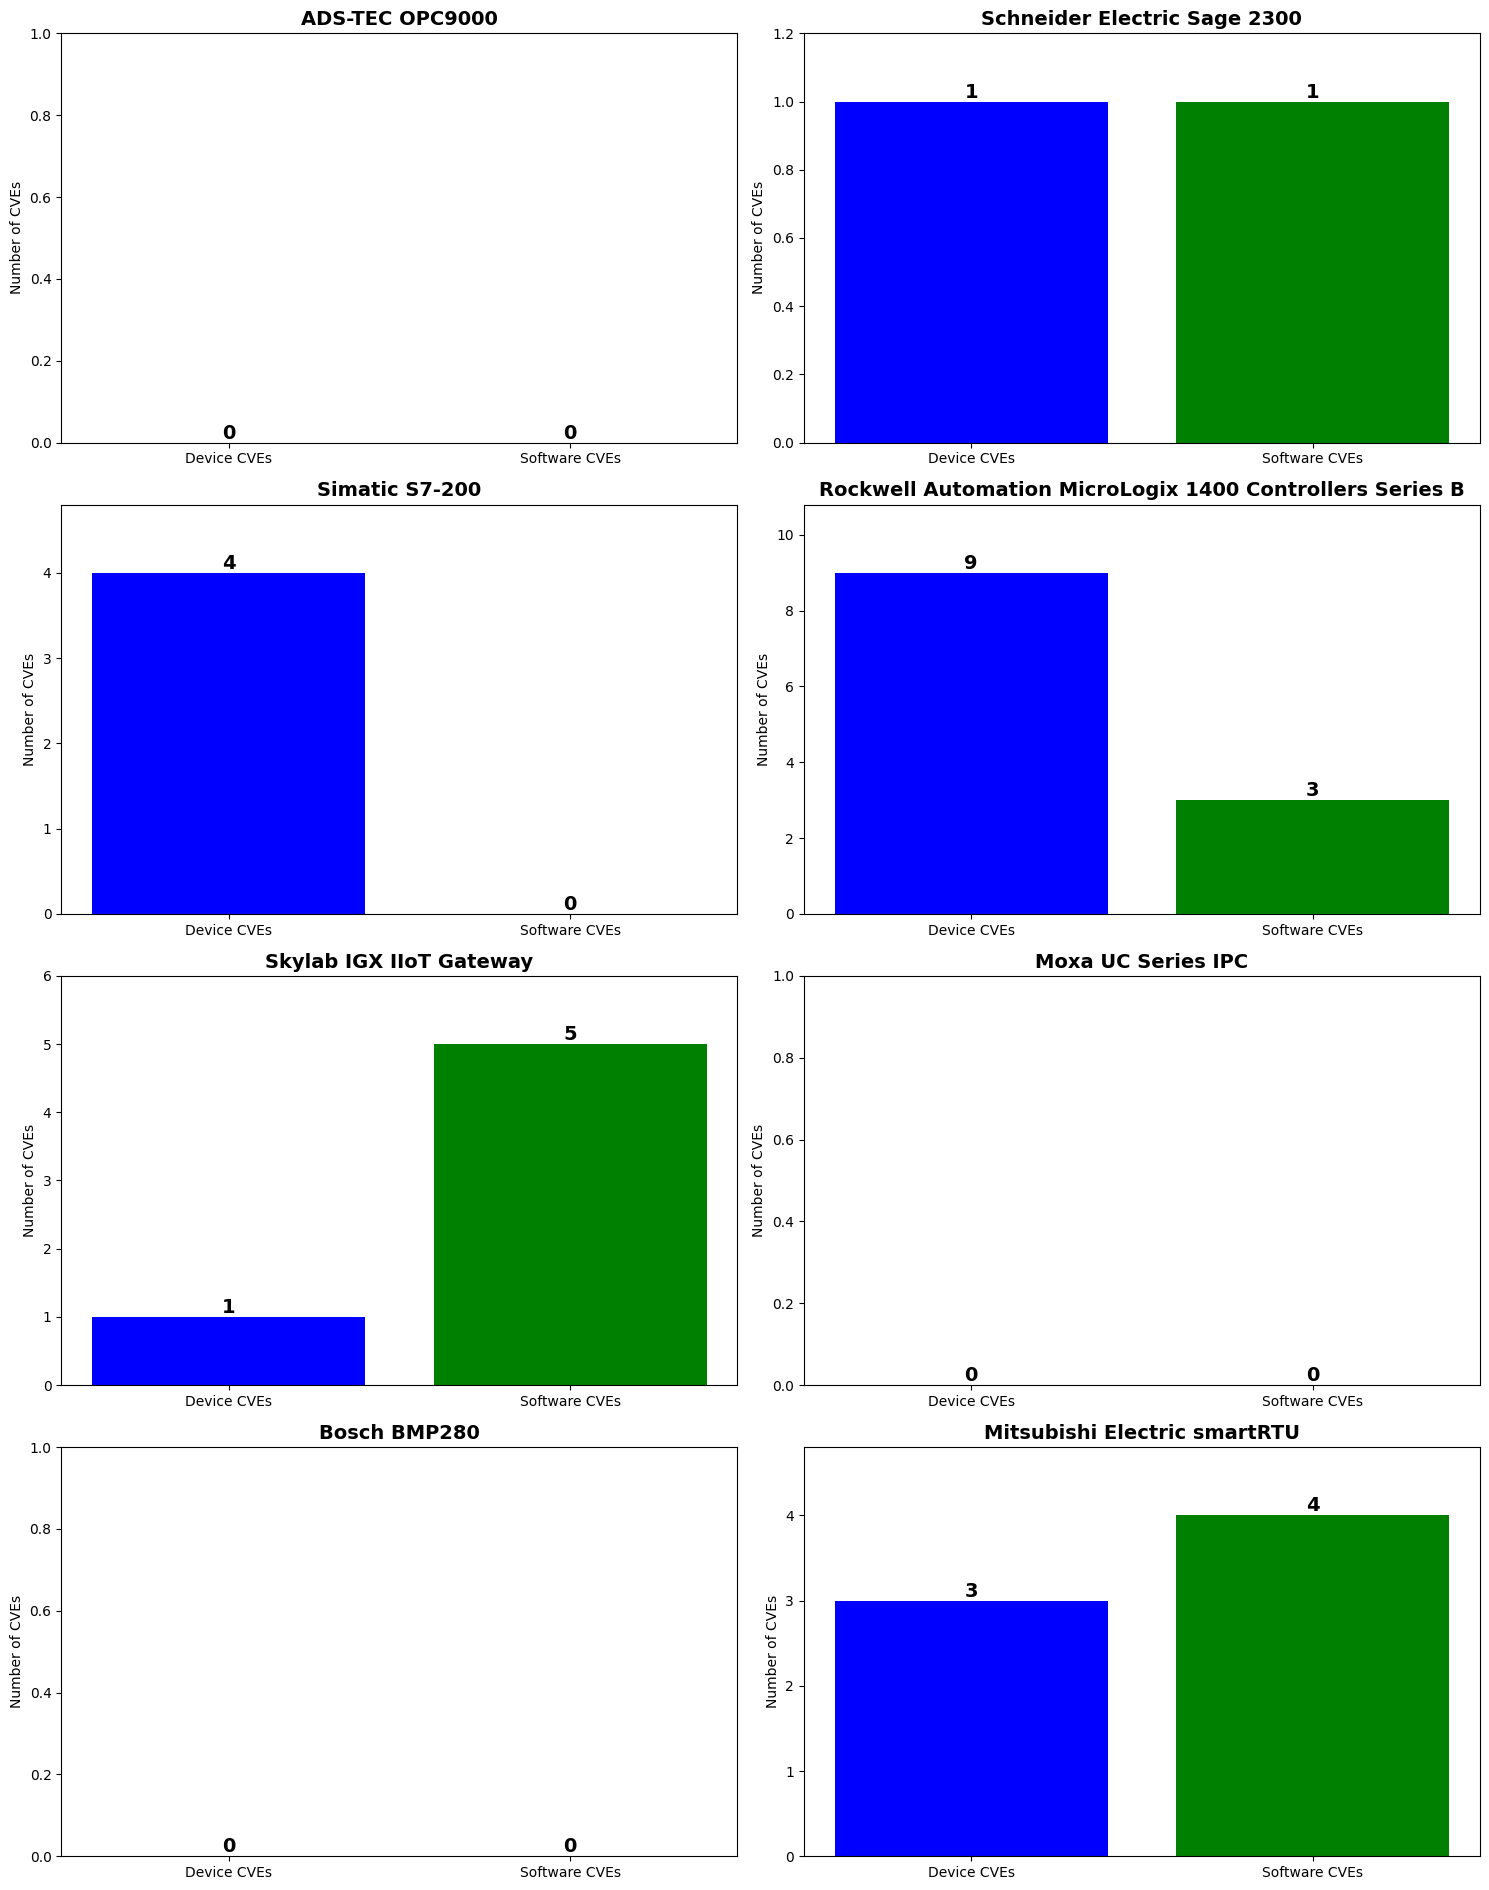

In [16]:
# Anzahl der Spalten und Zeilen für die Diagramme
rows, cols = 4, 2


fig, axs = plt.subplots(rows, cols, figsize=(15, 20))  # Angepasst für 2x4 Layout

# Durch die Geräte und Software iterieren und die Diagramme in einem Grid anordnen
for idx, (device, software) in enumerate(cleaned_device_software_pairs[:rows * cols]):
    # Zählen der CVEs pro Gerät
    device_cve_count = df_device_cve_data[df_device_cve_data['Device'] == device]['CVE ID'].apply(lambda x: 0 if x == 'N/A' else 1).sum()
    
    # Zählen der CVEs für die Software
    software_cve_count = df_software_cve_data[df_software_cve_data['Software'] == software]['CVE ID'].apply(lambda x: 0 if x == 'N/A' else 1).sum()
    
    # Erstellen des Balkendiagramms
    labels = ['Device CVEs', 'Software CVEs']
    values = [device_cve_count, software_cve_count]

    # Berechnen der Position im Grid
    row = idx // cols
    col = idx % cols

    axs[row, col].bar(labels, values, color=['blue', 'green'])
    
    # Titel Layout anpassen
    axs[row, col].set_title(f'{device}', fontweight='bold', fontsize=14)
    axs[row, col].set_ylabel('Number of CVEs')

    # Den Bereich der y-Achse anpassen
    if max(values) == 0:
        axs[row, col].set_ylim(0, 1)
    else:
        axs[row, col].set_ylim(0, max(values) * 1.2)

    # Anzahl der CVEs über den Balken anzeigen
    for i, value in enumerate(values):
        axs[row, col].text(i, value, str(value), ha='center', va='bottom', fontweight='bold', fontsize=14)

# Überflüssige Subplots ausblenden, wenn weniger als 8 Diagramme erstellt werden
if len(cleaned_device_software_pairs[:rows * cols]) < rows * cols:
    for idx in range(len(device_software_pairs_new), rows * cols):
        fig.delaxes(axs.flatten()[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Platz für den Supertitel lassen
plt.savefig('cve_counts_devices_software.pdf', format='pdf')  
plt.show()

# Filtern nach gewünschten CVEs

In [70]:
cve_type = input("Möchten Sie Hardware- oder Software-CVEs abfragen? (hardware/software): ").strip().lower()

if cve_type == "hardware":
    item_type = input("Bitte geben Sie den Gerätetyp ein oder 'alle' für alle Geräte: ").strip()
    
    df_to_use = df_device_cve_data

    # Spaltenname "Device" für die Filterung
    column_name = "Device"

elif cve_type == "software":
    item_type = input("Bitte geben Sie die Software ein oder 'alle' für alle Software: ").strip()
    
    df_to_use = df_software_cve_data

    # Spaltenname "Software" für die Filterung
    column_name = "Software"

else:
    print("Ungültige Eingabe. Bitte wählen Sie 'hardware' oder 'software'.")
    exit()

year = input("Bitte geben Sie das Jahr ein oder 'alle' für alle Jahre: ").strip()

# Konvertieren der "Published Date"-Spalte in Strings, falls sie nicht bereits String-Typ ist
df_to_use["Published Date"] = df_to_use["Published Date"].astype(str)

if item_type.lower() != "alle":
    df_filtered = df_to_use[df_to_use[column_name].str.contains(item_type, case=False, na=False)]
else:
    df_filtered = df_to_use

# Daten filtern nach Jahr anhand des Veröffentlichungsdatums
if year.lower() != "alle":
    df_filtered = df_filtered[df_filtered["Published Date"].str[:4] == year]

# Überprüfen, ob gefilterte Daten vorhanden sind
if df_filtered.empty:
    print("No Entries found. Please try again.")
else:
    # Sortieren der gefilterten Daten nach Gerätetyp/Software und anschließend nach dem Veröffentlichungsdatum
    df_filtered = df_filtered.sort_values(by=[column_name, 'Published Date'], ascending=[True, False])

    # Erstellen eines neuen DataFrames
    df_selected_columns = df_filtered[[column_name, "CVE ID", "Description", "Published Date", "Last Modified Date", "EPSS Score", "CVSS Score", "CVSS Severity"]]

    print(df_selected_columns)

    # CVE Descritpions speichern, für spätere Weiterverarbeitung
    filtered_cve_descriptions = df_selected_columns["Description"].tolist()

Möchten Sie Hardware- oder Software-CVEs abfragen? (hardware/software):  software
Bitte geben Sie die Software ein oder 'alle' für alle Software:  rsl
Bitte geben Sie das Jahr ein oder 'alle' für alle Jahre:  alle


   Software         CVE ID  \
13  RSLogix  CVE-2020-6990   
12  RSLogix  CVE-2020-6988   
7   RSLogix  CVE-2016-5814   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Description  \
13                                                                                   Rockwell Automation MicroLogix 1400 Controllers Series B v21.001 and prior, Series A, all versions, MicroLogix 1100 Controller, all versions, RSLogix 500 Software v12.001 and prior, The cryptographic key utilized to help p

In [73]:
df_selected_columns

,Software,CVE ID,Description,Published Date,Last Modified Date,EPSS Score,CVSS Score,CVSS Severity
13,RSLogix,CVE-2020-6990,"Rockwell Automation MicroLogix 1400 Controllers Series B v21.001 and prior, Series A, all versions, MicroLogix 1100 Controller, all versions, RSLogix 500 Software v12.001 and prior, The cryptographic key utilized to help protect the account password is hard coded into the RSLogix 500 binary file. An attacker could identify cryptographic keys and use it for further cryptographic attacks that could ultimately lead to a remote attacker gaining unauthorized access to the controller.",2020-03-16 16:15:14.843,2020-03-20T15:09:40.937,0.023670000,9.8,CRITICAL
12,RSLogix,CVE-2020-6988,"Rockwell Automation MicroLogix 1400 Controllers Series B v21.001 and prior, Series A, all versions, MicroLogix 1100 Controller, all versions, RSLogix 500 Software v12.001 and prior, A remote, unauthenticated attacker can send a request from the RSLogix 500 software to the victim’s MicroLogix controller. The controller will then respond to the client with used password values to authenticate the user on the client-side. This method of authentication may allow an attacker to bypass authentication altogether, disclose sensitive information, or leak credentials.",2020-03-16 16:15:14.767,2020-03-20T14:29:14.390,0.001220000,7.5,HIGH
7,RSLogix,CVE-2016-5814,"Buffer overflow in Rockwell Automation RSLogix Micro Starter Lite, RSLogix Micro Developer, RSLogix 500 Starter Edition, RSLogix 500 Standard Edition, and RSLogix 500 Professional Edition allows remote attackers to execute arbitrary code via a crafted RSS project file.",2016-09-19 01:59:05.133,2016-11-28T20:29:37.580,0.022670000,8.6,HIGH


# Mapping CVE - ATT&CK

In [9]:
# Pfad zum Verzeichnis hinzufügen
sys.path.append(os.path.abspath("C:/Users/Marce/Masterarbeit"))

In [76]:
# Laden der id2mitre JSON-Datei
id2mitre=funs.read_json_as_dict("C:/Users/Marce/Masterarbeit/SMET/id2mitre.json") #add your path 

# Umkehrung der JSON-Zuordnung
mitre2id = {value: key for key, value in id2mitre.items()}

# Schleife zum durchlaufen der CVE Descriptions
for cve_description in filtered_cve_descriptions:
    mapping = map_text(cve_description, CVE=True)
    
    # Speichern der ersten fünf Ergebnisse
    top_five_results = mapping[:5]
    
    # Abgleichen der Techniken mit ATT&CK-IDs
    mapped_attack_ids = [(mitre2id.get(technique[0], "Unknown ATT&CK ID"), technique[0], technique[1]) for technique in top_five_results]
    print("Mapped ATT&CK IDs for top five results:", mapped_attack_ids)


Mapped ATT&CK IDs for top five results: [('T1140', 'Deobfuscate/Decode Files or Information', 0.15960692083821829), ('T1573', 'Encrypted Channel', 0.1485706040884034), ('T1110', 'Brute Force', 0.11955861348978546), ('T1556', 'Modify Authentication Process', 0.106210936163401), ('T1600', 'Weaken Encryption', 0.10083904827592284)]
Mapped ATT&CK IDs for top five results: [('T1550', 'Use Alternate Authentication Material', 0.20669988572157563), ('T1598', 'Phishing for Information', 0.14594406109379715), ('T1187', 'Forced Authentication', 0.12425103991579722), ('T1556', 'Modify Authentication Process', 0.12013761253859835), ('T1110', 'Brute Force', 0.10728950493934084)]
Mapped ATT&CK IDs for top five results: [('T1203', 'Exploitation for Client Execution', 0.11109051249291373), ('T1102', 'Web Service', 0.10273700244772473), ('T1218', 'System Binary Proxy Execution', 0.08688156982972477), ('T1059', 'Command and Scripting Interpreter', 0.06946202291261543), ('T1106', 'Native API', 0.060458674

# Diagramm für HW

In [34]:
try:
    # Mapping der ATT&CK IDs zu CVE IDs
    cve_to_attack_ids = {}
    for index, row in df_selected_columns.iterrows():
        cve_id = row['CVE ID']
        cve_description = row['Description']
        mapping = map_text(cve_description, CVE=True)
        top_five_results = mapping[:5]
        mapped_attack_ids = [(mitre2id.get(technique[0], "Unknown ATT&CK ID"), technique[0], technique[1]) for technique in top_five_results]
        cve_to_attack_ids[cve_id] = mapped_attack_ids

    # Entsprechenden Gerätebezeichnung extrahieren
    device_name = df_selected_columns['Device'].iloc[0]

    # Gültigen Dateinamen für die Speicherung des Diagramms erstellen 
    safe_device_name = ''.join(c for c in device_name if c.isalnum() or c in (' ', '_', '-')).rstrip()

    # Diagramm erstellen
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i, (cve_id, attack_ids) in enumerate(cve_to_attack_ids.items()):
        attack_ids_str = [aid[0] for aid in attack_ids]
        scores = [aid[2] for aid in attack_ids]
        bars = ax.barh([f"{cve_id} - {aid}" for aid in attack_ids_str], scores, color=colors[i % len(colors)], label=cve_id)

        # Namen der ATT&CK ID rechts neben dem Balken anzeigen
        for bar, attack_id_tuple in zip(bars, attack_ids):
            wrapped_text = textwrap.fill(attack_id_tuple[1], width=40)  # Text auf 20 Zeichen pro Zeile umbrechen
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, wrapped_text, 
                    va='center', ha='left', fontsize=9, color='black')

    # Dynamischer Titel mit dem Hardware-Namen
    ax.set_xlabel('Scores')
    ax.set_title(f'ATT&CK IDs mapped to CVEs for hardware: {device_name}')
    ax.legend(title='CVE ID')

    plt.tight_layout()

    output_dir = r'C:/Users/Marce/Masterarbeit/Diagramme' #add your path 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output_filename = os.path.join(output_dir, f'cve_counts_{safe_device_name}.pdf')
    
    plt.savefig(output_filename, format='pdf')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: 'Device'


# Diagramm Erstellung für SW

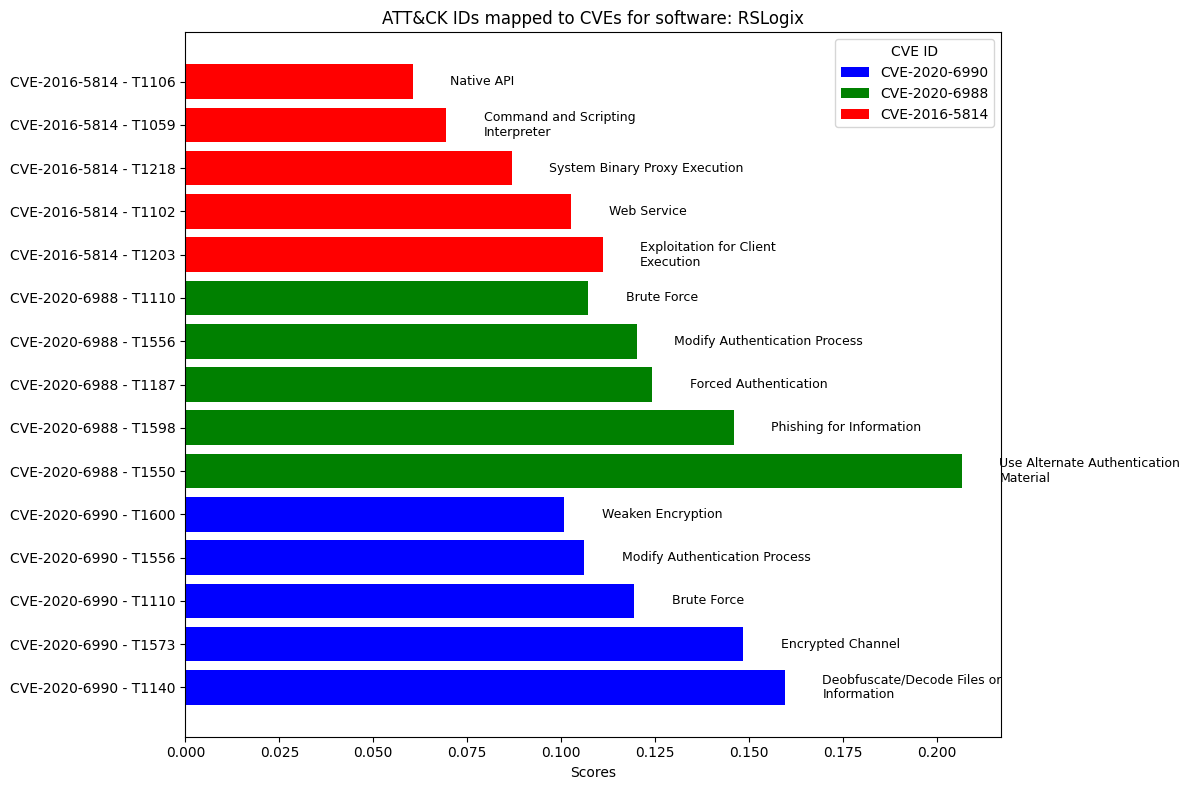

In [77]:
cve_to_attack_ids = {}
for index, row in df_selected_columns.iterrows():
    cve_id = row['CVE ID']
    cve_description = row['Description']
    mapping = map_text(cve_description, CVE=True)
    top_five_results = mapping[:5]
    mapped_attack_ids = [(mitre2id.get(technique[0], "Unknown ATT&CK ID"), technique[0], technique[1]) for technique in top_five_results]
    cve_to_attack_ids[cve_id] = mapped_attack_ids

# Softwarebezeichnung extrahieren 
software_name = df_selected_columns['Software'].iloc[0]

# Gültigen Dateinamen für die Speicherung des Diagramms erstellen
safe_software_name = ''.join(c for c in software_name if c.isalnum() or c in (' ', '_', '-')).rstrip()

# Diagramm erstellen
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, (cve_id, attack_ids) in enumerate(cve_to_attack_ids.items()):
    attack_ids_str = [aid[0] for aid in attack_ids]
    scores = [aid[2] for aid in attack_ids]
    bars = ax.barh([f"{cve_id} - {aid}" for aid in attack_ids_str], scores, color=colors[i % len(colors)], label=cve_id)
    
    # Namen der ATT&CK ID rechts neben dem Balken anzeigen und den Text umbrechen
    for bar, attack_id_tuple in zip(bars, attack_ids):
        wrapped_text = textwrap.fill(attack_id_tuple[1], width=30)
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, wrapped_text, 
                va='center', ha='left', fontsize=9, color='black')

# Dynamischer Titel mit dem Software-Namen
ax.set_xlabel('Scores')
ax.set_title(f'ATT&CK IDs mapped to CVEs for software: {software_name}')
ax.legend(title='CVE ID')

plt.tight_layout()

output_filename = os.path.join(r'C:/Users/Marce/Masterarbeit/Diagramme/', f'cve_counts_{safe_software_name}.pdf') #add your path 
plt.savefig(output_filename, format='pdf') 
plt.show()

# Mapping ATT&CK - Mitigations

In [58]:
# URL to MITRE ATT&CK dataset
url = "https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json"

response = requests.get(url)
data = response.json()

# JSON Daten Normalisieren und als df speichern
techniques = pd.json_normalize(data['objects'])
relationships = pd.json_normalize(data['objects'])
mitigations = pd.json_normalize(data['objects'])

# Filtern nach benötigten Informationen
attack_techniques = techniques[techniques['type'] == 'attack-pattern']
attack_relationships = relationships[relationships['type'] == 'relationship']
attack_mitigations = mitigations[mitigations['type'] == 'course-of-action']

# Mapped die Angriffstechniken mit ihren entsprechenden Mitigations
def map_techniques_to_mitigations():
    technique_to_mitigation = {}
    for index, row in attack_relationships.iterrows():
        if row['relationship_type'] == 'mitigates':
            technique_id = row['target_ref']
            mitigation_id = row['source_ref']
            
            technique_data = attack_techniques[attack_techniques['id'] == technique_id][['name', 'external_references']].values
            mitigation_data = attack_mitigations[attack_mitigations['id'] == mitigation_id][['name', 'external_references']].values
            
            if technique_data.size > 0 and mitigation_data.size > 0:
                technique_name = technique_data[0][0]
                
                # ID Für Angriffstechnik extrahieren
                technique_external_id = None
                for ref in technique_data[0][1]:
                    if ref.get('source_name') == 'mitre-attack':
                        technique_external_id = ref.get('external_id')
                        break
                
                mitigation_name = mitigation_data[0][0]
                
                # ID für Mitigation extrahieren 
                mitigation_external_id = None
                for ref in mitigation_data[0][1]:
                    if ref.get('source_name') == 'mitre-attack':
                        mitigation_external_id = ref.get('external_id')
                        break
                
                technique_key = f"{technique_name} (ID: {technique_external_id})"
                
                if technique_key not in technique_to_mitigation:
                    technique_to_mitigation[technique_key] = []
                
                technique_to_mitigation[technique_key].append(f"{mitigation_name} (ID: {mitigation_external_id})")
    
    return technique_to_mitigation

# Map Angriffstechnik zu Mitigation
technique_to_mitigation_map = map_techniques_to_mitigations()

technique_mitigation_df = pd.DataFrame([
    {"Technique": technique, "Mitigations": mitigations}
    for technique, mitigations in technique_to_mitigation_map.items()
])

all_results = []

# Verarbeitung der CVE Einträge
for cve_entry, mappings in cve_to_attack_ids.items():
    for attack_id, description, score in mappings:
        row = technique_mitigation_df[technique_mitigation_df['Technique'].str.contains(f"ID: {attack_id}")]
        if not row.empty:
            mitigations = row.iloc[0]['Mitigations']
        else:
            mitigations = "No Mitigations Found"
        all_results.append((cve_entry, attack_id, description, score, mitigations))

all_results_df = pd.DataFrame(all_results, columns=['CVE ID', 'Attack ID', 'Description', 'Score', 'Mitigations'])

# Zusammenfügen der dataframes um CVSS, EPSS, and CVSS Severity zu übernehmen 
final_df = pd.merge(all_results_df, df_selected_columns[['CVE ID', 'CVSS Score', 'EPSS Score', 'CVSS Severity']], on='CVE ID', how='left')

#final_df

# Mapping Mitigations - D3fend Maßnahmen

In [64]:
url = 'https://d3fend.mitre.org/mappings/attack-mitigations/'
txt_file_path = 'C:/Users/Marce/Masterarbeit/Zusatzinfos_Verteidigungsmaßnahmen_cleaned.txt' #add your path 

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

mitigations = []
defenses = []

# Extrahieren der Mitigationen und Verteidigungsmaßnahmen
table = soup.find('table')
for row in table.find_all('tr')[1:]:  # Überspringe die Kopfzeile
    cols = row.find_all('td')
    mitigation_id = cols[0].text.strip()
    mitigation_name = cols[1].text.strip()
    defense_measure = cols[2].text.strip()
    mitigations.append((mitigation_id, mitigation_name))
    defenses.append(defense_measure)

# Erstellen eines DataFrames aus den gescrapten Daten
mitigation_defense_mapping_df = pd.DataFrame(mitigations, columns=['Mitigation ID', 'Mitigation Name'])
mitigation_defense_mapping_df['Defense Measure'] = defenses

# Funktion zum Extrahieren der Mitigation IDs aus der Liste
def extract_mitigation_ids(mitigation_list):
    if isinstance(mitigation_list, str) and "No Mitigations Found" in mitigation_list:
        return ["No Mitigations for this ATT&CK Number"]
    
    mitigation_ids = []
    for item in mitigation_list:
        if " (ID: " in item:
            mitigation_ids.append(item.split(' (ID: ')[1][:-1])
        else:
            mitigation_ids.append("Unknown ID")
    return mitigation_ids

# Funktion zum Einfügen von Kommas vor "D3-" und Entfernen von Leerzeichen vor Kommas für bessere Lesbarkeit
def format_defense_measures(defense_str):
    measures = defense_str.split('  ')
    measures = [measure.strip() for measure in measures]
    return measures

# Datei (Zusatzinfos zu Verteidigungen) Zeile für Zeile einlesen und den Inhalt überprüfen
with open(txt_file_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter=';', quotechar='"')
    lines = list(reader)

# Bereinigen & Normalisieren der Daten
cleaned_lines = []
for line in lines:
    # Zusammenfügen der Felder, die durch Kommas getrennt 
    if len(line) > 5:
        merged_line = [line[0], line[1], line[2], line[3], line[4], ','.join(line[5:])]
        cleaned_lines.append(merged_line)
    else:
        cleaned_lines.append(line)

# Erstellen eines DataFrames aus den bereinigten Zeilen  
headers = cleaned_lines[0]
data = cleaned_lines[1:]
defense_txt_df = pd.DataFrame(data, columns=headers)

# Bereinigen und Normalisieren der Spalte 'Related D3FEND Techniques' im df
defense_txt_df['Related D3FEND Techniques'] = defense_txt_df['Related D3FEND Techniques'].apply(lambda x: x.strip().lower())

# Hinzufügen der Defense Measures zu all_results_df basierend auf Mitigation ID
def get_defense_measures(mitigation_list):
    if mitigation_list == ["No Mitigations for this ATT&CK Number"]:
        return ["No Mitigations for this ATT&CK Number"]
    
    mitigation_ids = extract_mitigation_ids(mitigation_list)
    defense_measures = []
    for mid in mitigation_ids:
        if mid != "Unknown ID":
            measures = mitigation_defense_mapping_df[mitigation_defense_mapping_df['Mitigation ID'] == mid]['Defense Measure'].values
            if measures.size > 0:
                defense_measures.append(measures[0])
            else:
                defense_measures.append('Not found')
        else:
            defense_measures.append('Not found')
    return defense_measures

all_results_df['Defense Measures'] = all_results_df['Mitigations'].apply(get_defense_measures)

# Ausgabe der Zusatzinformationen (Print Befehle dienen nur der Überprüfung) 
def display_defense_info_with_details(defense_measures, mitigation_id):
    if mitigation_id in ["Unknown ID", "No Mitigations for this ATT&CK Number"]:
        print(f"Mitigation ID: {mitigation_id}")
        print("Details: No Mitigations for this ATT&CK Number")
        print("="*50 + "\n")
        return

    formatted_defense_measures = format_defense_measures(defense_measures)
    for measure in formatted_defense_measures:
        measure_lower = measure.strip().lower()
        defense_info = defense_txt_df[defense_txt_df['Related D3FEND Techniques'] == measure_lower]
        
        if not defense_info.empty:
            for index, row in defense_info.iterrows():
                print(f"Defense Measure: {row['Related D3FEND Techniques'].upper()}")
                print(f"Definition: {row['Definition']}")
                print(f"How it works: {row['How it works']}")
                print(f"Considerations: {row['Considerations']}")
                if row['Implementations'] and row['Implementations'].strip().lower() != 'none':
                    print(f"Implementations: {row['Implementations']}")
                else:
                    print("Implementations: Not available")
                if row['Examples'] and row['Examples'].strip().lower() != 'none':
                    print(f"Examples: {row['Examples']}")
                else:
                    print("Examples: Not available")
                print()
        else:
            print(f"Defense Measure: {measure.upper()}")
            print("Details: Not found\n")

In [65]:
all_results_df

,CVE ID,Attack ID,Description,Score,Mitigations,Defense Measures
0,CVE-2020-6990,T1140,Deobfuscate/Decode Files or Information,0.159607,No Mitigations Found,[Not found]
1,CVE-2020-6990,T1573,Encrypted Channel,0.148571,[Network Intrusion Prevention (ID: M1031)],[D3-ITF Inbound Traffic Filtering D3-NTA Network Traffic Analysis D3-OTF Outbound Traffic Filtering]
2,CVE-2020-6990,T1110,Brute Force,0.119559,"[Update Software (ID: M1051), Multi-factor Authentication (ID: M1032), Password Policies (ID: M1027), Account Use Policies (ID: M1036)]","[D3-SU Software Update, D3-MFA Multi-factor Authentication, D3-OTP One-time Password D3-SPP Strong Password Policy, D3-AL Account Locking D3-ANCI Authentication Cache Invalidation D3-ANET Authentication Event Thresholding]"
3,CVE-2020-6990,T1556,Modify Authentication Process,0.106211,"[Privileged Account Management (ID: M1026), Password Policies (ID: M1027)]","[D3-DAM Domain Account Monitoring D3-LAM Local Account Monitoring D3-SPP Strong Password Policy, D3-OTP One-time Password D3-SPP Strong Password Policy]"
4,CVE-2020-6990,T1600,Weaken Encryption,0.100839,No Mitigations Found,[Not found]
5,CVE-2020-6988,T1550,Use Alternate Authentication Material,0.206700,"[Privileged Account Management (ID: M1026), Password Policies (ID: M1027), User Account Management (ID: M1018), Active Directory Configuration (ID: M1015)]","[D3-DAM Domain Account Monitoring D3-LAM Local Account Monitoring D3-SPP Strong Password Policy, D3-OTP One-time Password D3-SPP Strong Password Policy, D3-LFP Local File Permissions D3-MAC Mandatory Access Control D3-SCP System Configuration Permissions, D3-ANCI Authentication Cache Invalidation D3-DTP Domain Trust Policy D3-UAP User Account Permissions]"
6,CVE-2020-6988,T1598,Phishing for Information,0.145944,"[User Training (ID: M1017), Software Configuration (ID: M1054)]","[, D3-ACH Application Configuration Hardening D3-CP Certificate Pinning]"
7,CVE-2020-6988,T1187,Forced Authentication,0.124251,"[Password Policies (ID: M1027), Filter Network Traffic (ID: M1037)]","[D3-OTP One-time Password D3-SPP Strong Password Policy, D3-NI Network Isolation]"
8,CVE-2020-6988,T1556,Modify Authentication Process,0.120138,"[Privileged Account Management (ID: M1026), Password Policies (ID: M1027)]","[D3-DAM Domain Account Monitoring D3-LAM Local Account Monitoring D3-SPP Strong Password Policy, D3-OTP One-time Password D3-SPP Strong Password Policy]"
9,CVE-2020-6988,T1110,Brute Force,0.107290,"[Update Software (ID: M1051), Multi-factor Authentication (ID: M1032), Password Policies (ID: M1027), Account Use Policies (ID: M1036)]","[D3-SU Software Update, D3-MFA Multi-factor Authentication, D3-OTP One-time Password D3-SPP Strong Password Policy, D3-AL Account Locking D3-ANCI Authentication Cache Invalidation D3-ANET Authentication Event Thresholding]"


# Erstellung Mitigation Tree für jede gefundene Schwachstelle (Software)

In [63]:
txt_file_path = 'C:/Users/Marce/Masterarbeit/Zusatzinfos_Verteidigungsmaßnahmen_cleaned.txt'
output_dir = r'C:/Users/Marce/Masterarbeit/Diagramme'

# Datei Zeile für Zeile einlesen und den Inhalt überprüfen
with open(txt_file_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter=';', quotechar='"')
    lines = list(reader)

# Bereinigen und Normalisieren der Daten
headers = lines[0]
data = lines[1:]
defense_txt_df = pd.DataFrame(data, columns=headers)

# Bereinigen und Normalisieren der Spalte 'Related D3FEND Techniques' im DataFrame
defense_txt_df['Related D3FEND Techniques'] = defense_txt_df['Related D3FEND Techniques'].apply(lambda x: x.strip().lower())

# Begründungen für fehlende Defense-Maßnahmen
missing_defense_reasons = {
    "M1013": "A future release of D3FEND will define a taxonomy of Source Code Hardening Techniques.",
    "M1016": "Future D3FEND releases will model the scanning and inventory domains.",
    "M1017": "Modeling user training is outside the scope of D3FEND.",
    "M1019": "Establishing and running a Threat Intelligence Program is outside the scope of D3FEND.",
    "M1029": "IT disaster recovery plans are outside the current scope of D3FEND.",
    "M1053": "Comprehensive IT disaster recovery plans are outside the current scope of D3FEND.",
    "M1055": "Could increase the risk of compromise."
}

# Funktion zum Erstellen der Mitigation Trees für eine Attack ID
def create_tree_diagram(cve_id, attack_id, attack_description, attack_score, mitigations, defense_measures, device_name, epss_score, cvss_score, cvss_severity):
    #  Anmerkung für Name, EPSS, CVSS und Severity
    dot = Digraph(comment=f'CVE ID: {cve_id}, Attack ID: {attack_id}')
    
    # Zusatzinformationen (Name, EPSS, CVSS und Severity) hinzufügen
    additional_info = (f"Software: {software_name}\n"
                       f"EPSS Score: {epss_score}\n"
                       f"CVSS Score: {cvss_score}\n"
                       f"CVSS Severity: {cvss_severity}")
    
    dot.node('Info', additional_info, shape='box', style='filled', color='lightblue')
    
    # CVE und Attack ID als Knoten hinzufügen, jetzt inklusive Beschreibung und Score
    attack_info = (f"Attack ID: {attack_id}\n"
                   f"Description: {attack_description}\n"
                   f"Score: {attack_score}")
    dot.node('CVE', f'CVE ID: {cve_id}')
    dot.node('Attack', attack_info)
    dot.edge('CVE', 'Attack')
    
    # Hinzufügen der Mitigations und Defense Measures
    if not mitigations or mitigations == "No Mitigations Found":
        # Falls keine Mitigations vorhanden sind, füge einen Knoten mit "No Mitigations Found" hinzu
        dot.node('NoMitigation', 'No Mitigations Found', shape='ellipse', style='filled', color='lightcoral')
        dot.edge('Attack', 'NoMitigation')
    else:
        for i, mitigation in enumerate(mitigations):
            if " (ID: " in mitigation:
                mitigation_id = mitigation.split(' (ID: ')[1][:-1]
                mitigation_name = mitigation.split(' (ID: ')[0]
                dot.node(f'M{i}', f'{mitigation_name} (ID: {mitigation_id})')
            else:
                # Falls keine ID vorhanden ist, setze einen Platzhalter
                mitigation_id = "Unknown"
                dot.node(f'M{i}', mitigation)

            dot.edge('Attack', f'M{i}')
            
            if mitigation_id in missing_defense_reasons:
                # Knoten anders markieren und Begründung hinzufügen
                reason = missing_defense_reasons[mitigation_id]
                dot.node(f'NoDefense{i}', f"No Defense Measure\nReason: {reason}", shape='ellipse', style='filled', color='lightcoral')
                dot.edge(f'M{i}', f'NoDefense{i}')
            elif i < len(defense_measures):
                measures = defense_measures[i].split('  ')  # Doppelte Leerzeichen als Trennzeichen verwenden
                for j, measure in enumerate(measures):
                    measure = measure.strip()
                    measure_node = f'M{i}-{measure}'
                    dot.node(measure_node, measure)
                    dot.edge(f'M{i}', measure_node)

                    # Zusatzinformationen hinzufügen
                    measure_info = defense_txt_df[defense_txt_df['Related D3FEND Techniques'] == measure.lower()]
                    if not measure_info.empty:
                        for index, row in measure_info.iterrows():
                            info_node = f'{measure_node}-info'
                            info_label = (f"Definition: {row['Definition']}\n"
                                          f"How it works: {row['How it works']}\n"
                                          f"Considerations: {row['Considerations']}\n"
                                          f"Implementations: {row['Implementations'] if row['Implementations'] != 'None' else 'No information available'}\n"
                                          f"Examples: {row['Examples'] if row['Examples'] != 'None' else 'No examples available'}")
                            dot.node(info_node, info_label, shape='box', style='filled', color='lightgrey')
                            dot.edge(measure_node, info_node)
                    else:
                        info_node = f'{measure_node}-info'
                        info_label = "No additional information available"
                        dot.node(info_node, info_label, shape='box', style='filled', color='lightgrey')
                        dot.edge(measure_node, info_node)
            else:
                # Falls keine Defense Measure für die Mitigation gefunden wurde
                dot.node(f'NoDefense{i}', f"No Defense Measures Found", shape='ellipse', style='filled', color='lightcoral')
                dot.edge(f'M{i}', f'NoDefense{i}')

    return dot

# Iterieren über die Zeilen in all_results_df und Erstellen der Baumdiagramme
for index, row in all_results_df.iterrows():
    cve_id = row['CVE ID']
    attack_id = row['Attack ID']
    attack_description = row['Description']  
    attack_score = row['Score']  # Relevanzscore der Attack ID hinzufügen
    mitigations = row['Mitigations']
    defense_measures = row['Defense Measures']

    # Holen der zusätzlichen Informationen aus dem DataFrame (Device, EPSS, CVSS und CVSS Severity)
    #device_name = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['Device'].values[0]
    software_name = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['Software'].values[0]
    epss_score = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['EPSS Score'].values[0]
    cvss_score = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['CVSS Score'].values[0]
    cvss_severity = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['CVSS Severity'].values[0]

    # Erstellen des Baumdiagramms mit den zusätzlichen Informationen
    tree_diagram = create_tree_diagram(cve_id, attack_id, attack_description, attack_score, mitigations, defense_measures, software_name, epss_score, cvss_score, cvss_severity)
    tree_diagram.render(os.path.join(output_dir, f'mitigation_tree_{cve_id}_{attack_id}'), format='pdf')


# Erstellung Mitigation Tree für jede gefundene Schwachstelle (Hardware)

In [ ]:
txt_file_path = 'C:/Users/Marce/Masterarbeit/Zusatzinfos_Verteidigungsmaßnahmen_cleaned.txt'
output_dir = r'C:/Users/Marce/Masterarbeit/Diagramme'

# Datei Zeile für Zeile einlesen und den Inhalt überprüfen
with open(txt_file_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter=';', quotechar='"')
    lines = list(reader)

# Bereinigen und Normalisieren der Daten
headers = lines[0]
data = lines[1:]
defense_txt_df = pd.DataFrame(data, columns=headers)

# Bereinigen und Normalisieren der Spalte 'Related D3FEND Techniques' im DataFrame
defense_txt_df['Related D3FEND Techniques'] = defense_txt_df['Related D3FEND Techniques'].apply(lambda x: x.strip().lower())

# Begründungen für fehlende Defense-Maßnahmen
missing_defense_reasons = {
    "M1013": "A future release of D3FEND will define a taxonomy of Source Code Hardening Techniques.",
    "M1016": "Future D3FEND releases will model the scanning and inventory domains.",
    "M1017": "Modeling user training is outside the scope of D3FEND.",
    "M1019": "Establishing and running a Threat Intelligence Program is outside the scope of D3FEND.",
    "M1029": "IT disaster recovery plans are outside the current scope of D3FEND.",
    "M1053": "Comprehensive IT disaster recovery plans are outside the current scope of D3FEND.",
    "M1055": "Could increase the risk of compromise."
}

# Funktion zum Erstellen der Mitigation Trees für eine Attack ID
def create_tree_diagram(cve_id, attack_id, attack_description, attack_score, mitigations, defense_measures, device_name, epss_score, cvss_score, cvss_severity):
    #  Anmerkung für Name, EPSS, CVSS und Severity
    dot = Digraph(comment=f'CVE ID: {cve_id}, Attack ID: {attack_id}')
    
    # Zusatzinformationen (Name, EPSS, CVSS und Severity) hinzufügen
    additional_info = (f"Hardware: {device_name}\n"
                       f"EPSS Score: {epss_score}\n"
                       f"CVSS Score: {cvss_score}\n"
                       f"CVSS Severity: {cvss_severity}")
    
    dot.node('Info', additional_info, shape='box', style='filled', color='lightblue')
    
    # CVE und Attack ID als Knoten hinzufügen, jetzt inklusive Beschreibung und Score
    attack_info = (f"Attack ID: {attack_id}\n"
                   f"Description: {attack_description}\n"
                   f"Score: {attack_score}")
    dot.node('CVE', f'CVE ID: {cve_id}')
    dot.node('Attack', attack_info)
    dot.edge('CVE', 'Attack')
    
    # Hinzufügen der Mitigations und Defense Measures
    if not mitigations or mitigations == "No Mitigations Found":
        # Falls keine Mitigations vorhanden sind, füge einen Knoten mit "No Mitigations Found" hinzu
        dot.node('NoMitigation', 'No Mitigations Found', shape='ellipse', style='filled', color='lightcoral')
        dot.edge('Attack', 'NoMitigation')
    else:
        for i, mitigation in enumerate(mitigations):
            if " (ID: " in mitigation:
                mitigation_id = mitigation.split(' (ID: ')[1][:-1]
                mitigation_name = mitigation.split(' (ID: ')[0]
                dot.node(f'M{i}', f'{mitigation_name} (ID: {mitigation_id})')
            else:
                # Falls keine ID vorhanden ist, setze einen Platzhalter
                mitigation_id = "Unknown"
                dot.node(f'M{i}', mitigation)

            dot.edge('Attack', f'M{i}')
            
            if mitigation_id in missing_defense_reasons:
                # Knoten anders markieren und Begründung hinzufügen
                reason = missing_defense_reasons[mitigation_id]
                dot.node(f'NoDefense{i}', f"No Defense Measure\nReason: {reason}", shape='ellipse', style='filled', color='lightcoral')
                dot.edge(f'M{i}', f'NoDefense{i}')
            elif i < len(defense_measures):
                measures = defense_measures[i].split('  ')  # Doppelte Leerzeichen als Trennzeichen verwenden
                for j, measure in enumerate(measures):
                    measure = measure.strip()
                    measure_node = f'M{i}-{measure}'
                    dot.node(measure_node, measure)
                    dot.edge(f'M{i}', measure_node)

                    # Zusatzinformationen hinzufügen
                    measure_info = defense_txt_df[defense_txt_df['Related D3FEND Techniques'] == measure.lower()]
                    if not measure_info.empty:
                        for index, row in measure_info.iterrows():
                            info_node = f'{measure_node}-info'
                            info_label = (f"Definition: {row['Definition']}\n"
                                          f"How it works: {row['How it works']}\n"
                                          f"Considerations: {row['Considerations']}\n"
                                          f"Implementations: {row['Implementations'] if row['Implementations'] != 'None' else 'No information available'}\n"
                                          f"Examples: {row['Examples'] if row['Examples'] != 'None' else 'No examples available'}")
                            dot.node(info_node, info_label, shape='box', style='filled', color='lightgrey')
                            dot.edge(measure_node, info_node)
                    else:
                        info_node = f'{measure_node}-info'
                        info_label = "No additional information available"
                        dot.node(info_node, info_label, shape='box', style='filled', color='lightgrey')
                        dot.edge(measure_node, info_node)
            else:
                # Falls keine Defense Measure für die Mitigation gefunden wurde
                dot.node(f'NoDefense{i}', f"No Defense Measures Found", shape='ellipse', style='filled', color='lightcoral')
                dot.edge(f'M{i}', f'NoDefense{i}')

    return dot

# Iterieren über die Zeilen in all_results_df und Erstellen der Baumdiagramme
for index, row in all_results_df.iterrows():
    cve_id = row['CVE ID']
    attack_id = row['Attack ID']
    attack_description = row['Description']  
    attack_score = row['Score']  # Relevanzscore der Attack ID hinzufügen
    mitigations = row['Mitigations']
    defense_measures = row['Defense Measures']

    # Holen der zusätzlichen Informationen aus dem DataFrame (Device, EPSS, CVSS und CVSS Severity)
    #device_name = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['Device'].values[0]
    device_name = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['Software'].values[0]
    epss_score = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['EPSS Score'].values[0]
    cvss_score = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['CVSS Score'].values[0]
    cvss_severity = df_selected_columns[df_selected_columns['CVE ID'] == cve_id]['CVSS Severity'].values[0]

    # Erstellen des Baumdiagramms mit den zusätzlichen Informationen
    tree_diagram = create_tree_diagram(cve_id, attack_id, attack_description, attack_score, mitigations, defense_measures, device_name, epss_score, cvss_score, cvss_severity)
    tree_diagram.render(os.path.join(output_dir, f'mitigation_tree_{cve_id}_{attack_id}'), format='pdf')


# Sortierte Ausgabe nach CVSS/EPSS Score

In [31]:
# Funktion zur Sortierung des DataFrames basierend auf der Nutzereingabe
def sort_dataframe(df):
    sort_criteria = input("Nach welchem Kriterium möchten Sie sortieren? (epss/cvss): ").strip().lower()
    
    if sort_criteria == "epss":
        df_sorted = df.sort_values(by="EPSS Score", ascending=False)
    elif sort_criteria == "cvss":
        df_sorted = df.sort_values(by="CVSS Score", ascending=False)
    else:
        print("Ungültige Eingabe. Bitte 'epss' oder 'cvss' eingeben.")
        return df  # Original DataFrame zurückgeben, wenn die Eingabe ungültig ist
    
    return df_sorted

df_sorted = sort_dataframe(df_selected_columns)

df_sorted

Nach welchem Kriterium möchten Sie sortieren? (epss/cvss):  epss


,Device,CVE ID,Description,Published Date,Last Modified Date,EPSS Score,CVSS Score,CVSS Severity
17,Skylab IGX IIoT Gateway,CVE-2024-4163,"The Skylab IGX IIoT Gateway allowed users to connect to it via a limited shell terminal (IGX). However, it was discovered that the process was running under root privileges. This allowed the attacker to read, write, and modify any file in the operating system by utilizing the limited shell file exec and download functions. By replacing the /etc/passwd file with a new root user entry, the attacker was able to breakout from the limited shell and login to a unrestricted shell with root access. With the root access, the attacker will be able take full control of the IIoT Gateway.",2024-04-26 03:15:06.740,2024-07-03T02:07:10.047,0.000430000,8.0,HIGH
